In [1]:
pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 5.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import yaml
import spotipy

In [3]:
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix, vstack
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize
from spotipy.oauth2 import SpotifyOAuth

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive'

Mounted at /content/drive
/content/drive/MyDrive


In [5]:
original_playlist_df = pd.read_pickle("playlist_tracks.pkl")

In [6]:
original_playlist_df.head()

,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,album_tracks,album_type,playlist_id,playlist_name,playlist_tracks,added_at,added_by,genres,album_genres,0
0,1fw27qkdvmfmpexxebF4mv,Ladies and Djents: Anatidaephobia,1,track,False,True,230244,1,4,2Hv4OejDkQZi21donA6QVq,...,14,album,6LTmMLBh0J9C9SZLhrjIge,Beyond the Horizon,56,2023-11-07T07:24:32Z,{'external_urls': {'spotify': 'https://open.sp...,[],[],"{'danceability': 0.53, 'energy': 0.766, 'key':..."
1,0yk2nMJan4aIcutQvUNLE9,Amazon,17,track,False,False,211320,1,1,2tK3yFyUDBZlQ5aqYmoDKC,...,15,album,6LTmMLBh0J9C9SZLhrjIge,Beyond the Horizon,56,2023-11-07T07:24:32Z,{'external_urls': {'spotify': 'https://open.sp...,[],[],"{'danceability': 0.243, 'energy': 0.628, 'key'..."
2,5COoeqw9IKfkHJIgXzu4M0,Robotman,0,track,False,False,242668,1,1,1dV1ZJ9YHEMAWB5ZkkoDGi,...,1,album,6LTmMLBh0J9C9SZLhrjIge,Beyond the Horizon,56,2023-11-07T07:24:32Z,{'external_urls': {'spotify': 'https://open.sp...,[],[],"{'danceability': 0.449, 'energy': 0.584, 'key'..."
3,44ot7aqyz0T5SbCvxwXoFp,to the last of a dying breed,12,track,False,False,223400,1,1,4EDxGYZZDNlYg4z7Y5HfyV,...,2,album,6LTmMLBh0J9C9SZLhrjIge,Beyond the Horizon,56,2023-11-07T07:24:32Z,{'external_urls': {'spotify': 'https://open.sp...,[],[],"{'danceability': 0.521, 'energy': 0.648, 'key'..."
4,3B0OAiREpeprwqAUdEdbUG,"Telescope - Live in Montgomery, AL, 2018",10,track,False,False,246961,1,8,2pXFmyqPm7wHJ1HGAwyR3L,...,9,album,6LTmMLBh0J9C9SZLhrjIge,Beyond the Horizon,56,2023-11-07T07:24:32Z,{'external_urls': {'spotify': 'https://open.sp...,[funk rock],[funk rock],"{'danceability': 0.691, 'energy': 0.739, 'key'..."


In [7]:
playlist_df = original_playlist_df[original_playlist_df['playlist_name'].isin(['Absence Echoes', 'Beyond the Horizon','Cleaning Kit','Pop Rising','Mega Hit Mix', 'Pop Road Trip','This Is Taylor Swift','Dance Hits of 2014','Heart Broken Blues','Fresh Finds','Top Songs - USA'])]

In [8]:
lyrics_df = pd.read_csv('filtered_data_en_2010_ne.csv')

In [9]:
playlist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925 entries, 0 to 924
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  925 non-null    object
 1   name                925 non-null    object
 2   popularity          925 non-null    int64 
 3   type                925 non-null    object
 4   is_local            925 non-null    bool  
 5   explicit            925 non-null    bool  
 6   duration_ms         925 non-null    int64 
 7   disc_number         925 non-null    int64 
 8   track_number        925 non-null    int64 
 9   artist_id           925 non-null    object
 10  artist_name         925 non-null    object
 11  album_artist_id     925 non-null    object
 12  album_artist_name   925 non-null    object
 13  album_id            925 non-null    object
 14  album_name          925 non-null    object
 15  album_release_date  925 non-null    object
 16  album_tracks        925 no

In [10]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664220 entries, 0 to 1664219
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   title          1664135 non-null  object
 1   tag            1664220 non-null  object
 2   artist         1664220 non-null  object
 3   year           1664220 non-null  int64 
 4   views          1664220 non-null  int64 
 5   features       1664220 non-null  object
 6   lyrics         1664220 non-null  object
 7   id             1664220 non-null  int64 
 8   language_cld3  1664220 non-null  object
 9   language_ft    1664220 non-null  object
 10  language       1664220 non-null  object
dtypes: int64(3), object(8)
memory usage: 139.7+ MB


In [11]:
#lyrics_df = lyrics_df.drop(columns=['id', 'tag', 'year', 'views', 'features', 'language_cld3', 'language_ft', 'language'], axis=1)

In [12]:
playlist_df['artist_name_1'] = playlist_df['artist_name'].str.lower()
lyrics_df['artist_name_1'] = lyrics_df['artist'].str.lower()
playlist_df['song_name'] = playlist_df['name'].str.lower()
lyrics_df['song_name'] = lyrics_df['title'].str.lower()

<ipython-input-12-9053e978cf1f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playlist_df['artist_name_1'] = playlist_df['artist_name'].str.lower()
<ipython-input-12-9053e978cf1f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playlist_df['song_name'] = playlist_df['name'].str.lower()


In [13]:
playlist_df = playlist_df.merge(lyrics_df, on=['song_name','artist_name_1'], how='inner')

In [14]:
playlist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 0 to 174
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id_x                175 non-null    object
 1   name                175 non-null    object
 2   popularity          175 non-null    int64 
 3   type                175 non-null    object
 4   is_local            175 non-null    bool  
 5   explicit            175 non-null    bool  
 6   duration_ms         175 non-null    int64 
 7   disc_number         175 non-null    int64 
 8   track_number        175 non-null    int64 
 9   artist_id           175 non-null    object
 10  artist_name         175 non-null    object
 11  album_artist_id     175 non-null    object
 12  album_artist_name   175 non-null    object
 13  album_id            175 non-null    object
 14  album_name          175 non-null    object
 15  album_release_date  175 non-null    object
 16  album_tracks        175 no

In [15]:
import plotly.express as px

# Group by artist_name and count the number of tracks for each artist
artist_counts = playlist_df['artist_name'].value_counts().reset_index()
artist_counts.columns = ['Artist', 'Track Count']

# Plotting top artists
fig_artists = px.bar(artist_counts.head(10), x='Artist', y='Track Count', title='Top 10 Artists with Most Tracks in the Playlist')

fig_artists.show()

In [16]:
import plotly.express as px

# Grouping by 'album_name' and counting the number of tracks for each album
album_counts = playlist_df['album_name'].value_counts().reset_index()
album_counts.columns = ['Album Name', 'Number of Tracks']

# Plotting the top albums with the most tracks in the playlist
fig_albums = px.bar(album_counts.head(10), x='Album Name', y='Number of Tracks', title='Top Albums with Most Tracks in the Playlist')
fig_albums.show()

In [17]:
# Grouping the dataframe by playlist_name and computing the average popularity for tracks in each playlist
average_popularity = playlist_df.groupby('playlist_name')['popularity'].mean().sort_values(ascending=False)

# Create a bar plot
import plotly.express as px

fig = px.bar(average_popularity, x=average_popularity.index, y=average_popularity.values, title="Average Popularity of Tracks by Playlist", labels={"y": "Average Popularity", "index": "Playlist Name"})
fig.show()


In [18]:
top_artist_df = pd.read_pickle("top_artists.pkl")
#followed_artists_df = pd.read_pickle("followed_artists.pkl")

In [19]:
top_artist_df.head()

,id,uri,type,name,genres,followers
0,1wRPtKGflJrBx9BmLsSwlU,spotify:artist:1wRPtKGflJrBx9BmLsSwlU,artist,Pritam,"[filmi, indian instrumental, modern bollywood]",0
1,06HL4z0CvFAxyc27GXpf02,spotify:artist:06HL4z0CvFAxyc27GXpf02,artist,Taylor Swift,[pop],0
2,6ltzsmQQbmdoHHbLZ4ZN25,spotify:artist:6ltzsmQQbmdoHHbLZ4ZN25,artist,Lord Huron,"[indie folk, stomp and holler]",0
3,7qjJw7ZM2ekDSahLXPjIlN,spotify:artist:7qjJw7ZM2ekDSahLXPjIlN,artist,Sid Sriram,[filmi],0
4,1mYsTxnqsietFxj1OgoGbG,spotify:artist:1mYsTxnqsietFxj1OgoGbG,artist,A.R. Rahman,[filmi],0


In [20]:
import pandas as pd
import plotly.express as px

# Load the pickle file for top artists
top_artists_df = pd.read_pickle("top_artists.pkl")

# Group the data by genre and count the number of artists in each genre
genre_counts = top_artists_df['genres'].explode().value_counts().reset_index()
genre_counts.columns = ['Genre', 'Artist Count']

# Create a bar chart to show the distribution of artists by genre
genre_fig = px.bar(
    genre_counts,
    x='Genre',
    y='Artist Count',
    title='Top Artists by Genre',
    labels={'Artist Count': 'Number of Artists'},
)

# Sort the genres by artist count in descending order
genre_fig.update_xaxes(categoryorder='total descending')

# Display the interactive plot
genre_fig.show()



In [21]:
followed_artists_df = pd.read_pickle("followed_artists.pkl")

In [22]:
followed_artists_df.head()

,id,uri,type,name,genres,followers
0,06HL4z0CvFAxyc27GXpf02,spotify:artist:06HL4z0CvFAxyc27GXpf02,artist,Taylor Swift,[pop],91476272
1,1Xyo4u8uXC1ZmMpatF05PJ,spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ,artist,The Weeknd,"[canadian contemporary r&b, canadian pop, pop]",73996091
2,1uNFoZAHBGtllmzznpCI3s,spotify:artist:1uNFoZAHBGtllmzznpCI3s,artist,Justin Bieber,"[canadian pop, pop]",74455904
3,1vCWHaC5f2uS3yhpwWbIA6,spotify:artist:1vCWHaC5f2uS3yhpwWbIA6,artist,Avicii,"[dance pop, edm, pop, pop dance]",23153559
4,4AK6F7OLvEQ5QYCBNiQWHq,spotify:artist:4AK6F7OLvEQ5QYCBNiQWHq,artist,One Direction,"[boy band, pop, post-teen pop, talent show]",33731164


In [23]:
top_tracks_df = pd.read_pickle("top_tracks.pkl")

In [24]:
top_tracks_df.head()

,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,album_artist_id,album_artist_name,album_id,album_name,album_release_date,album_tracks,album_type,genres,album_genres,0
0,1fnyJEbolobEfv2gtLVjmA,Kabhi Na Kabhi,54,track,False,False,376049,1,5,4Z0t0LHjOjFRiv0mjBw206,...,1Fp2NbOlCFFrrkc29QbhBC,Chirantan Bhatt,63LMMLbw96iKJ2pSsJuatw,Shaapit: The Cursed,2010-02-09,7,album,"[filmi, modern bollywood]",[],"{'danceability': 0.724, 'energy': 0.684, 'key'..."
1,5iydgkuP2lJFDT9CgyY26x,Jaadui,53,track,False,False,222375,1,5,1wRPtKGflJrBx9BmLsSwlU,...,1wRPtKGflJrBx9BmLsSwlU,Pritam,1t1gWslYejaaqicumEbdKU,Tu Jhoothi Main Makkaar,2023-03-16,6,album,"[filmi, indian instrumental, modern bollywood]","[filmi, indian instrumental, modern bollywood]","{'danceability': 0.589, 'energy': 0.419, 'key'..."
2,4i4PJCJ0DYyUfXVHLS4fYU,Piharva,35,track,False,False,430967,1,1,1nmKYy6efdYl8sIcT0gCLJ,...,1nmKYy6efdYl8sIcT0gCLJ,Anumita Nadesan,1RGxnno01axq8lp4TTdwhn,Piharva,2022-02-14,1,album,"[desi pop, indian indie, indian singer-songwri...","[desi pop, indian indie, indian singer-songwri...","{'danceability': 0.341, 'energy': 0.594, 'key'..."
3,34Tp5CGIrrqIZ5bJcc2Lc3,Alai Alaiyaaga - Extended Version,27,track,False,False,179585,1,12,0LSPREIgGMZXCuKVel7LVD,...,0LyfQWJT6nXafLPZqxe9Of,Various Artists,6D95duFqeI9jThSo6UnVfF,Navarasa (Original Motion Picture Soundtrack),2022-02-14,12,album,[filmi],[],"{'danceability': 0.362, 'energy': 0.2, 'key': ..."
4,0QZ5yyl6B6utIWkxeBDxQN,The Night We Met,83,track,False,False,208211,1,14,6ltzsmQQbmdoHHbLZ4ZN25,...,6ltzsmQQbmdoHHbLZ4ZN25,Lord Huron,3yoNZlqerJnsnMN5EDwwBS,Strange Trails,2015-04-07,14,album,"[indie folk, stomp and holler]","[indie folk, stomp and holler]","{'danceability': 0.545, 'energy': 0.366, 'key'..."


In [25]:
top_tracks_df.columns

Index([                'id',               'name',         'popularity',
                     'type',           'is_local',           'explicit',
              'duration_ms',        'disc_number',       'track_number',
                'artist_id',        'artist_name',    'album_artist_id',
        'album_artist_name',           'album_id',         'album_name',
       'album_release_date',       'album_tracks',         'album_type',
                   'genres',       'album_genres',                    0],
      dtype='object')

In [26]:
#top_tracks_df[0]
features_df = top_tracks_df[0].apply(pd.Series)


In [27]:
features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.724,0.684,1,-5.766,0,0.0306,0.658,0.000116,0.1080,0.609,112.005,audio_features,1fnyJEbolobEfv2gtLVjmA,spotify:track:1fnyJEbolobEfv2gtLVjmA,https://api.spotify.com/v1/tracks/1fnyJEbolobE...,https://api.spotify.com/v1/audio-analysis/1fny...,376050,4
1,0.589,0.419,7,-10.485,1,0.0265,0.866,0.000009,0.1360,0.437,102.973,audio_features,5iydgkuP2lJFDT9CgyY26x,spotify:track:5iydgkuP2lJFDT9CgyY26x,https://api.spotify.com/v1/tracks/5iydgkuP2lJF...,https://api.spotify.com/v1/audio-analysis/5iyd...,222376,4
2,0.341,0.594,3,-10.238,1,0.0445,0.670,0.035300,0.0724,0.153,93.007,audio_features,4i4PJCJ0DYyUfXVHLS4fYU,spotify:track:4i4PJCJ0DYyUfXVHLS4fYU,https://api.spotify.com/v1/tracks/4i4PJCJ0DYyU...,https://api.spotify.com/v1/audio-analysis/4i4P...,430968,4
3,0.362,0.200,2,-12.603,0,0.0372,0.926,0.000000,0.1190,0.457,143.226,audio_features,34Tp5CGIrrqIZ5bJcc2Lc3,spotify:track:34Tp5CGIrrqIZ5bJcc2Lc3,https://api.spotify.com/v1/tracks/34Tp5CGIrrqI...,https://api.spotify.com/v1/audio-analysis/34Tp...,179585,4
4,0.545,0.366,2,-9.510,1,0.0378,0.969,0.267000,0.6410,0.100,86.997,audio_features,0QZ5yyl6B6utIWkxeBDxQN,spotify:track:0QZ5yyl6B6utIWkxeBDxQN,https://api.spotify.com/v1/tracks/0QZ5yyl6B6ut...,https://api.spotify.com/v1/audio-analysis/0QZ5...,208212,3


In [28]:
saved_tracks_df = pd.read_pickle("saved_tracks.pkl")

In [29]:
saved_tracks_df.head()

,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,album_artist_name,album_id,album_name,album_release_date,album_tracks,album_type,added_at,genres,album_genres,0
0,3PfIrDoz19wz7qK7tYeu62,Don't Start Now,84,track,False,False,183290,1,2,6M2wZ9GZgrQXHCFfjv46we,...,Dua Lipa,7fJJK56U9fHixgO0HQkhtI,Future Nostalgia,2020-03-27,11,album,2023-11-07T16:18:53Z,"[dance pop, pop, uk pop]","[dance pop, pop, uk pop]","{'danceability': 0.793, 'energy': 0.793, 'key'..."
1,5nujrmhLynf4yMoMtj8AQF,Levitating (feat. DaBaby),85,track,False,False,203064,1,12,6M2wZ9GZgrQXHCFfjv46we,...,Dua Lipa,5lKlFlReHOLShQKyRv6AL9,Future Nostalgia,2020-03-27,13,album,2023-11-07T16:18:51Z,"[dance pop, pop, uk pop]","[dance pop, pop, uk pop]","{'danceability': 0.702, 'energy': 0.825, 'key'..."
2,3OHfY25tqY28d16oZczHc8,Kill Bill,87,track,False,False,153946,1,2,7tYKF4w9nC0nq9CsPZTHyP,...,SZA,07w0rG5TETcyihsEIZR3qG,SOS,2022-12-09,23,album,2023-11-07T16:18:33Z,"[pop, r&b, rap]","[pop, r&b, rap]","{'danceability': 0.644, 'energy': 0.728, 'key'..."
3,6WrI0LAC5M1Rw2MnX2ZvEg,Don't Start Now,79,track,False,False,183290,1,1,6M2wZ9GZgrQXHCFfjv46we,...,Dua Lipa,0ix3XtPV1LwmZADsprKxcp,Don't Start Now,2019-10-31,1,album,2023-11-07T16:16:53Z,"[dance pop, pop, uk pop]","[dance pop, pop, uk pop]","{'danceability': 0.794, 'energy': 0.793, 'key'..."
4,3C0nOe05EIt1390bVABLyN,On The Floor,81,track,False,False,284866,1,1,2DlGxzQSjYe5N6G9nkYghR,...,Jennifer Lopez,3sysiYphqNRQw7VKLCg1yE,Love?,2011-01-01,17,album,2023-11-07T16:16:45Z,"[dance pop, pop, urban contemporary]","[dance pop, pop, urban contemporary]","{'danceability': 0.73, 'energy': 0.777, 'key':..."


In [30]:
saved_tracks_df.columns

Index([                'id',               'name',         'popularity',
                     'type',           'is_local',           'explicit',
              'duration_ms',        'disc_number',       'track_number',
                'artist_id',        'artist_name',    'album_artist_id',
        'album_artist_name',           'album_id',         'album_name',
       'album_release_date',       'album_tracks',         'album_type',
                 'added_at',             'genres',       'album_genres',
                          0],
      dtype='object')

<ipython-input-31-dd6c59399541>:9: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



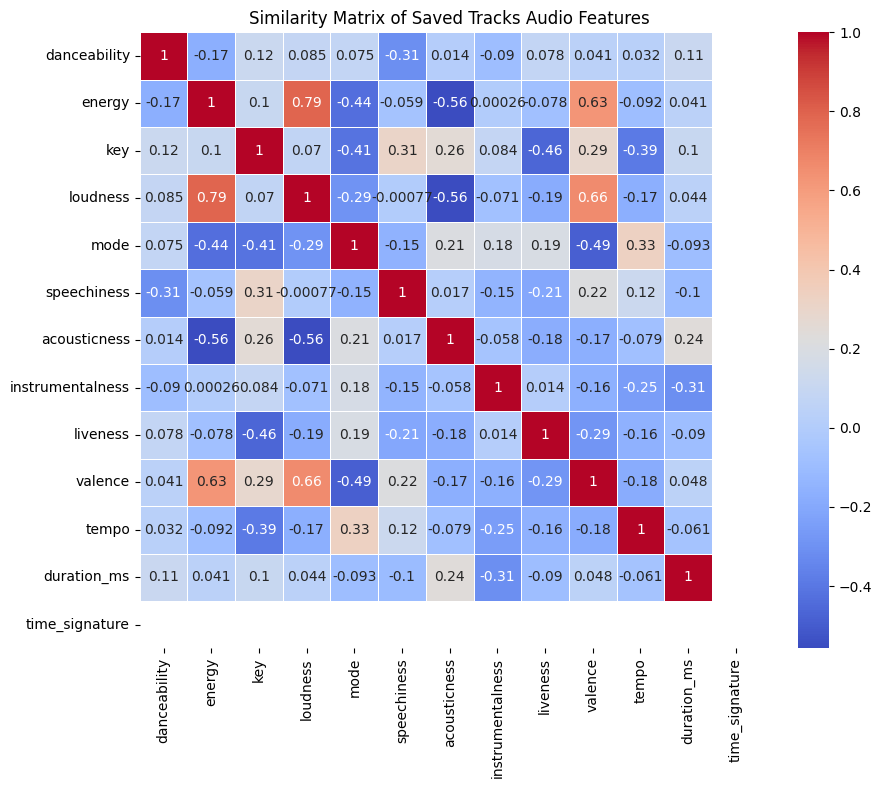

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract audio features from the 'saved_tracks_df[0]' column
audio_features = saved_tracks_df[0].apply(pd.Series)

# Calculate the similarity matrix (cosine similarity)
similarity_matrix = audio_features.corr()

# Create a heatmap to visualize the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Similarity Matrix of Saved Tracks Audio Features')
plt.show()



In [32]:
import pandas as pd
import plotly.express as px

# Load the pickle files
top_tracks_df = pd.read_pickle("top_tracks.pkl")
top_artists_df = pd.read_pickle("top_artists.pkl")

# Get the top 10 most played songs
top_10_tracks = top_tracks_df.head(10)

# Create a bar chart for the top 10 tracks
track_fig = px.bar(
    top_10_tracks,
    x='name',
    y='popularity',
    title='Top 10 Most Played Songs',
    labels={'popularity': 'Popularity Score'},
    hover_data=['name'],  # Specify 'artists' as hover data
)

# Get the top 10 most followed artists
top_10_artists = followed_artists_df.head(10)

# Create a bar chart for the top 10 artists
artist_fig = px.bar(
    top_10_artists,
    x='name',
    y='followers',
    title='Top 10 Most Followed Artists',
    labels={'followers': 'Followers Count'},
)

# Display the interactive plots
track_fig.show()
artist_fig.show()


In [33]:
playlist_df['popularity'] = playlist_df['popularity'] / 100  # normalise popularity feature between 0 and 1
playlist_df.head()

,id_x,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,tag,artist,year,views,features,lyrics,id_y,language_cld3,language_ft,language
0,1fw27qkdvmfmpexxebF4mv,Ladies and Djents: Anatidaephobia,0.01,track,False,True,230244,1,4,2Hv4OejDkQZi21donA6QVq,...,rock,Dropping a Popped Locket,2020,3,{},"[Intro]\nAngel with no wings, wings, but I?m s...",5735593,en,en,en
1,0yk2nMJan4aIcutQvUNLE9,Amazon,0.17,track,False,False,211320,1,1,2tK3yFyUDBZlQ5aqYmoDKC,...,rap,Swoopy,2020,1015,"{""?spira me""}","[Intro]\n(Opal)\n(Boysnightsout, only time I a...",5977687,en,en,en
2,5COoeqw9IKfkHJIgXzu4M0,Robotman,0.00,track,False,False,242668,1,1,1dV1ZJ9YHEMAWB5ZkkoDGi,...,pop,Typical Dreamers,2020,7,{},[Verse 1]\nI remember sunny days\nWhen we were...,5860735,en,en,en
3,44ot7aqyz0T5SbCvxwXoFp,to the last of a dying breed,0.12,track,False,False,223400,1,1,4EDxGYZZDNlYg4z7Y5HfyV,...,pop,Wu Am I,2020,262,{},[Verse 1]\nGrab your guitar\nLet?s karaoke on ...,6255633,en,en,en
4,2RtwGHs3qjxlDAwoMcUCT3,Details,0.42,track,False,False,237226,1,7,2vGA5qCDLZGW6exRQgKfLL,...,pop,Sarah Reeves,2017,12292,{},[Verse 1]\nYou drew the lines of my fingerprin...,3183511,en,en,en


In [47]:
with open("playlists.yml", 'r') as stream:
    playlist_ids = yaml.safe_load(stream)

In [35]:
playlist_df.head()

,id_x,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,tag,artist,year,views,features,lyrics,id_y,language_cld3,language_ft,language
0,1fw27qkdvmfmpexxebF4mv,Ladies and Djents: Anatidaephobia,0.01,track,False,True,230244,1,4,2Hv4OejDkQZi21donA6QVq,...,rock,Dropping a Popped Locket,2020,3,{},"[Intro]\nAngel with no wings, wings, but I?m s...",5735593,en,en,en
1,0yk2nMJan4aIcutQvUNLE9,Amazon,0.17,track,False,False,211320,1,1,2tK3yFyUDBZlQ5aqYmoDKC,...,rap,Swoopy,2020,1015,"{""?spira me""}","[Intro]\n(Opal)\n(Boysnightsout, only time I a...",5977687,en,en,en
2,5COoeqw9IKfkHJIgXzu4M0,Robotman,0.00,track,False,False,242668,1,1,1dV1ZJ9YHEMAWB5ZkkoDGi,...,pop,Typical Dreamers,2020,7,{},[Verse 1]\nI remember sunny days\nWhen we were...,5860735,en,en,en
3,44ot7aqyz0T5SbCvxwXoFp,to the last of a dying breed,0.12,track,False,False,223400,1,1,4EDxGYZZDNlYg4z7Y5HfyV,...,pop,Wu Am I,2020,262,{},[Verse 1]\nGrab your guitar\nLet?s karaoke on ...,6255633,en,en,en
4,2RtwGHs3qjxlDAwoMcUCT3,Details,0.42,track,False,False,237226,1,7,2vGA5qCDLZGW6exRQgKfLL,...,pop,Sarah Reeves,2017,12292,{},[Verse 1]\nYou drew the lines of my fingerprin...,3183511,en,en,en


In [36]:
playlist_features=playlist_df[0].apply(pd.Series)
playlist_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.530,0.766,9,-9.499,0,0.0893,0.00111,0.070700,0.1280,0.372,145.986,audio_features,1fw27qkdvmfmpexxebF4mv,spotify:track:1fw27qkdvmfmpexxebF4mv,https://api.spotify.com/v1/tracks/1fw27qkdvmfm...,https://api.spotify.com/v1/audio-analysis/1fw2...,230245,4
1,0.243,0.628,3,-6.750,1,0.0803,0.02780,0.000026,0.2450,0.203,59.780,audio_features,0yk2nMJan4aIcutQvUNLE9,spotify:track:0yk2nMJan4aIcutQvUNLE9,https://api.spotify.com/v1/tracks/0yk2nMJan4aI...,https://api.spotify.com/v1/audio-analysis/0yk2...,211320,3
2,0.449,0.584,4,-6.496,1,0.0426,0.01940,0.000004,0.1110,0.206,117.944,audio_features,5COoeqw9IKfkHJIgXzu4M0,spotify:track:5COoeqw9IKfkHJIgXzu4M0,https://api.spotify.com/v1/tracks/5COoeqw9IKfk...,https://api.spotify.com/v1/audio-analysis/5COo...,242669,4
3,0.521,0.648,5,-10.031,1,0.0341,0.46500,0.000131,0.1010,0.442,115.025,audio_features,44ot7aqyz0T5SbCvxwXoFp,spotify:track:44ot7aqyz0T5SbCvxwXoFp,https://api.spotify.com/v1/tracks/44ot7aqyz0T5...,https://api.spotify.com/v1/audio-analysis/44ot...,223400,4
4,0.540,0.743,6,-6.271,1,0.1020,0.04870,0.000007,0.1230,0.312,156.079,audio_features,2RtwGHs3qjxlDAwoMcUCT3,spotify:track:2RtwGHs3qjxlDAwoMcUCT3,https://api.spotify.com/v1/tracks/2RtwGHs3qjxl...,https://api.spotify.com/v1/audio-analysis/2Rtw...,237227,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.530,0.712,0,-8.135,1,0.0461,0.44000,0.023300,0.0931,0.577,167.964,audio_features,73W5aXorr5vxrySFcoZqIN,spotify:track:73W5aXorr5vxrySFcoZqIN,https://api.spotify.com/v1/tracks/73W5aXorr5vx...,https://api.spotify.com/v1/audio-analysis/73W5...,254467,4
171,0.624,0.691,0,-6.686,0,0.1960,0.06040,0.000011,0.1380,0.284,160.024,audio_features,7I7JbDv63ZJJsSi24DyJrz,spotify:track:7I7JbDv63ZJJsSi24DyJrz,https://api.spotify.com/v1/tracks/7I7JbDv63ZJJ...,https://api.spotify.com/v1/audio-analysis/7I7J...,211507,4
172,0.712,0.732,4,-6.754,1,0.0629,0.45400,0.000000,0.3190,0.313,94.071,audio_features,2dgFqt3w9xIQRjhPtwNk3D,spotify:track:2dgFqt3w9xIQRjhPtwNk3D,https://api.spotify.com/v1/tracks/2dgFqt3w9xIQ...,https://api.spotify.com/v1/audio-analysis/2dgF...,198533,4
173,0.739,0.320,11,-10.862,0,0.2390,0.73600,0.000147,0.1110,0.351,79.970,audio_features,5hQSXkFgbxjZo9uCwd11so,spotify:track:5hQSXkFgbxjZo9uCwd11so,https://api.spotify.com/v1/tracks/5hQSXkFgbxjZ...,https://api.spotify.com/v1/audio-analysis/5hQS...,200307,4


In [37]:
playlist_df.columns

Index([              'id_x',               'name',         'popularity',
                     'type',           'is_local',           'explicit',
              'duration_ms',        'disc_number',       'track_number',
                'artist_id',        'artist_name',    'album_artist_id',
        'album_artist_name',           'album_id',         'album_name',
       'album_release_date',       'album_tracks',         'album_type',
              'playlist_id',      'playlist_name',    'playlist_tracks',
                 'added_at',           'added_by',             'genres',
             'album_genres',                    0,      'artist_name_1',
                'song_name',              'title',                'tag',
                   'artist',               'year',              'views',
                 'features',             'lyrics',               'id_y',
            'language_cld3',        'language_ft',           'language'],
      dtype='object')

In [128]:
# Merge the extracted features back into the main dataframe
expanded_playlist_df = pd.concat([playlist_df, playlist_features], axis=1)

# Group by 'playlist_name' and compute the mean for each feature
average_features_per_playlist = expanded_playlist_df.groupby('playlist_name').mean().reset_index()

# Display the results
print(average_features_per_playlist[['playlist_name', 'popularity','danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']])

          playlist_name  popularity  danceability    energy  loudness  \
0        Absence Echoes    0.106667      0.492167  0.581500 -8.006167   
1    Beyond the Horizon    0.160250      0.520675  0.644798 -7.789775   
2          Cleaning Kit    0.802727      0.762091  0.719455 -5.322727   
3           Fresh Finds    0.500000      0.802000  0.594000 -8.094000   
4    Heart Broken Blues    0.192333      0.513110  0.564780 -9.093133   
5          Mega Hit Mix    0.871333      0.641533  0.603933 -5.991800   
6         Pop Road Trip    0.831613      0.696581  0.705226 -5.022774   
7  This Is Taylor Swift    0.828750      0.665792  0.583125 -7.600042   
8       Top Songs - USA    0.945000      0.460500  0.447000 -8.929000   

   speechiness  acousticness  instrumentalness  liveness   valence       tempo  
0     0.126350      0.431050          0.006944  0.183283  0.322500  104.453000  
1     0.071337      0.224029          0.112202  0.179062  0.415975  119.901175  
2     0.069264      0.1267

<ipython-input-128-802b0dec6482>:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [130]:
import plotly.graph_objs as go

In [131]:
# Selecting features for the radar chart
radar_features = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Normalizing loudness and tempo since they are on different scales
max_loudness = average_features_per_playlist['loudness'].max()
min_loudness = average_features_per_playlist['loudness'].min()
max_tempo = average_features_per_playlist['tempo'].max()
min_tempo = average_features_per_playlist['tempo'].min()

average_features_per_playlist['loudness'] = (average_features_per_playlist['loudness'] - min_loudness) / (max_loudness - min_loudness)
average_features_per_playlist['tempo'] = (average_features_per_playlist['tempo'] - min_tempo) / (max_tempo - min_tempo)

# Creating the radar chart
fig = go.Figure()

for index, row in average_features_per_playlist.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[radar_features].values,
        theta=radar_features,
        fill='toself',
        name=row['playlist_name']
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title="Musical Characteristics of Playlists"
)

fig.show()


In [55]:
import plotly.express as px

# Group by artist_name and count the number of tracks for each artist
artist_counts = playlist_df['artist_name'].value_counts().reset_index()
artist_counts.columns = ['Artist', 'Track Count']

# Plotting top artists
fig_artists = px.bar(artist_counts.head(10), x='Artist', y='Track Count', title='Top 10 Artists with Most Tracks in the Playlist')

fig_artists.show()

In [56]:
import plotly.express as px

# Grouping by 'album_name' and counting the number of tracks for each album
album_counts = playlist_df['album_name'].value_counts().reset_index()
album_counts.columns = ['Album Name', 'Number of Tracks']

# Plotting the top albums with the most tracks in the playlist
fig_albums = px.bar(album_counts.head(10), x='Album Name', y='Number of Tracks', title='Top Albums with Most Tracks in the Playlist')
fig_albums.show()

In [57]:
# Grouping the dataframe by playlist_name and computing the average popularity for tracks in each playlist
average_popularity = playlist_df.groupby('playlist_name')['popularity'].mean().sort_values(ascending=False)

# Create a bar plot
import plotly.express as px

fig = px.bar(average_popularity, x=average_popularity.index, y=average_popularity.values, title="Average Popularity of Tracks by Playlist", labels={"y": "Average Popularity", "index": "Playlist Name"})
fig.show()

In [58]:
import plotly.express as px

# Counting the number of occurrences of each unique 'playlist_name'
tracks_per_playlist = playlist_df['playlist_name'].value_counts().sort_values(ascending=False)

# Creating the bar chart
fig = px.bar(tracks_per_playlist,
             x=tracks_per_playlist.index,
             y=tracks_per_playlist.values,
             title="Number of Tracks by Playlist",
             labels={"y": "Number of Tracks", "index": "Playlist Name"})

fig.show()


In [59]:
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix, vstack
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize


In [110]:
playlist_df.columns

Index([              'id_x',               'name',         'popularity',
                     'type',           'is_local',           'explicit',
              'duration_ms',        'disc_number',       'track_number',
                'artist_id',        'artist_name',    'album_artist_id',
        'album_artist_name',           'album_id',         'album_name',
       'album_release_date',       'album_tracks',         'album_type',
              'playlist_id',      'playlist_name',    'playlist_tracks',
                 'added_at',           'added_by',             'genres',
             'album_genres',                    0,      'artist_name_1',
                'song_name',              'title',                'tag',
                   'artist',               'year',              'views',
                 'features',             'lyrics',               'id_y',
            'language_cld3',        'language_ft',           'language',
         'processed_lyrics',         'genres_str', 

In [111]:
def get_interacted_tracks(tracks, playlist_id, drop_duplicates=True):
    interacted_track_ids = set(tracks[tracks['playlist_id'] == playlist_id]['id_x'])
    tracks_interacted = tracks[tracks['id_x'].isin(interacted_track_ids)]
    tracks_not_interacted = tracks[~tracks['id_x'].isin(interacted_track_ids)]

    if drop_duplicates is True:
        tracks_interacted = tracks_interacted.drop_duplicates(subset='id_x', keep="first").reset_index()
        tracks_not_interacted = tracks_not_interacted.drop_duplicates(subset='id_x', keep="first").reset_index()

    return tracks_interacted, tracks_not_interacted

In [112]:
interacted_tracks, non_interacted_tracks = get_interacted_tracks(playlist_df, playlist_ids['Top Songs - USA'])

## Content Based Recommender

In [72]:
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [73]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop_words = nltk.corpus.stopwords.words('english')
wn = WordNetLemmatizer()
ps = PorterStemmer()

def normalize_document(doc):
    # remove all strings inside [ ]
    doc = re.sub(r'\[.*?\]', '', doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = doc.replace("nbsp","")
    # tokenize document
    tokens = nltk.word_tokenize(doc)

     # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # lemmatization
    lemmatized_tokens = [wn.lemmatize(token) for token in filtered_tokens if token not in stop_words]

    # stemming
    stemmed_tokens = [ps.stem(token) for token in lemmatized_tokens]

    # re-create document from filtered tokens
    doc = ' '.join(stemmed_tokens)
    return doc

#normalize_corpus = np.vectorize(normalize_document)

#norm_corpus = normalize_corpus(list(df['description']))
#len(norm_corpus)

In [74]:
playlist_df['processed_lyrics'] = playlist_df['lyrics'].apply(normalize_document)

In [75]:
def get_tfidf(tracks, ngram_range=(1,3), min_df=3, max_df=0.5, max_features=10000):
    # Transform list cols to string, we use bigrams later so no need to remove spaces
    tracks['genres_str'] = tracks['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

    # Vector size 5000 model
    vectorizer = TfidfVectorizer(analyzer='word',
                                 ngram_range=ngram_range,
                                 min_df=min_df,
                                 max_df=max_df,
                                 max_features=max_features,
                                 stop_words=stopwords.words('english'))  # might need to download stopwords, follow prompt

    # Don't include album_genres column here as similar to genres column and we don't want additional genre weighting in this case
    # vectorizer.fit_transform takes a string
    #tracks['name'].fillna("", inplace=True)
    #tracks['artist_name'].fillna("", inplace=True)
    #tracks['album_name'].fillna("", inplace=True)
    #tracks['playlist_name'].fillna("", inplace=True)
    #tracks['genres_str'].fillna("", inplace=True)
    tfidf_matrix = vectorizer.fit_transform(tracks['processed_lyrics']
                                           )
    tfidf_feature_names = vectorizer.get_feature_names_out()

    return tfidf_matrix, tfidf_feature_names

In [76]:
tfidf_matrix, tfidf_feature_names = get_tfidf(playlist_df)
tfidf_matrix

<175x1284 sparse matrix of type '<class 'numpy.float64'>'
	with 10597 stored elements in Compressed Sparse Row format>

In [83]:
def get_track_profile(tracks, track_id, tfidf_matrix):
    track_id_str = str(track_id)
    idx = tracks['id_x'].tolist().index(track_id)
    track_profile = tfidf_matrix[idx:idx+1]
    return track_profile

def get_track_profiles(tracks, track_ids, tfidf_matrix):
    track_profiles_list = [get_track_profile(tracks, x, tfidf_matrix) for x in track_ids]
    track_profiles = vstack(track_profiles_list)
    return track_profiles

def build_playlists_profile(tracks, playlist_id, interactions_indexed_df, tfidf_matrix):
    # There isn't any weighting we want to do in this case,
    # but a common approach is weighting by interaction strength (liking, commenting, etc.)
    interaction_tracks_df = interactions_indexed_df.loc[playlist_id]  # duplicate interacted tracks, filter to current playlist
    if isinstance(interaction_tracks_df, pd.DataFrame):
        track_ids = interaction_tracks_df['id_x'].tolist()
    else:
        track_ids = [interaction_tracks_df['id_x']]
    playlist_track_profiles = get_track_profiles(tracks, track_ids, tfidf_matrix)
    # Weighted average for event strengths
#     playlist_track_strengths = np.array(interaction_tracks_df['event_strength']).reshape(-1,1)
#     playlist_track_profiles_array = np.sum(playlist_track_profiles.multiply(playlist_track_strengths), axis=0) / np.sum(playlist_track_strengths)
    playlist_track_profiles_array = np.sum(playlist_track_profiles, axis=0)  # Flattens no_tracksx948 matrix to 1x948 array
    playlist_track_profiles_norm = normalize(np.asarray(playlist_track_profiles_array))
    return playlist_track_profiles_norm

def build_playlists_profiles(tracks, tfidf_matrix):
    playlist_profiles = {}
    for playlist_id in tracks['playlist_id'].unique():
        print("Processing playlist:", playlist_id)
        if pd.isna(playlist_id):  # Check for NaN playlist IDs
            continue
        interacted_tracks, non_interacted_tracks = get_interacted_tracks(tracks, playlist_id, drop_duplicates=False)
        playlist_profiles[playlist_id] = build_playlists_profile(tracks, playlist_id, interacted_tracks.set_index('playlist_id'), tfidf_matrix)
    return playlist_profiles

In [84]:
# Remove rows with NaN playlist IDs
playlist_df = playlist_df.dropna(subset=['playlist_id'])


In [85]:
# Execute the functions
tfidf_matrix, tfidf_feature_names = get_tfidf(playlist_df)
playlist_profiles = build_playlists_profiles(playlist_df, tfidf_matrix)
len(playlist_profiles), len(playlist_df['playlist_id'].unique())  # Check if all playlists are accounted for


Processing playlist: 6LTmMLBh0J9C9SZLhrjIge
Processing playlist: 18DAngmG2QeKJM5X8DaEox
Processing playlist: 37i9dQZF1DX5oYC8mRiXUR
Processing playlist: 4z8HzLjzFtJqfeVzmGcWOM
Processing playlist: 37i9dQZF1DWSVpJBtEkFud
Processing playlist: 37i9dQZF1DXbYM3nMM0oPk
Processing playlist: 37i9dQZF1DX5KpP2LN299J
Processing playlist: 37i9dQZEVXbLp5XoPON0wI
Processing playlist: 37i9dQZF1DWWjGdmeTyeJ6


(9, 9)

In [86]:
# Get the keywords for my "This Is Taylor Swift" playlist
swift_profile = playlist_profiles[playlist_ids['This Is Taylor Swift']]
print(swift_profile.shape)  # 95 songs of vector length 948
pd.DataFrame(sorted(zip(tfidf_feature_names, swift_profile.flatten().tolist()), key=lambda x: -x[1])[:10],  # sort by value desc
             columns=['token', 'relevance'])

(1, 1284)


,token,relevance
0,want,0.203833
1,isnt,0.170452
2,na,0.167048
3,id,0.163873
4,wan,0.162213
5,wan na,0.162213
6,love,0.153766
7,oh,0.141813
8,see,0.138013
9,dont wan,0.123952


In [89]:
class ContentRecommender:

    def __init__(self, tracks, tfidf_matrix, playlist_profiles):
        self.tracks = tracks
        self.tfidf_matrix = tfidf_matrix
        self.playlist_profiles = playlist_profiles
        self.model_name = 'Content-based Recommender'

    def _get_similar_tracks(self, playlist_id):
        #Computes the cosine similarity between the playlist profile and all profiles
        cosine_similarities = cosine_similarity(self.playlist_profiles[playlist_id], self.tfidf_matrix)
        similar_indices = cosine_similarities.argsort().flatten()
        #Sort the similar tracks by similarity
        similar_tracks = sorted([(self.tracks['id_x'].tolist()[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_tracks

    def recommend_tracks(self, playlist_id, ignore_ids=[]):
        similar_tracks = self._get_similar_tracks(playlist_id)
        similar_tracks_non_interacted = list(filter(lambda x: x[0] not in ignore_ids, similar_tracks))
        recommendations_df = pd.DataFrame(similar_tracks_non_interacted, columns=['id_x', 'recStrength']) \
                                .drop_duplicates(subset='id_x', keep="first").reset_index() \
                                .sort_values('recStrength', ascending=False)

        return recommendations_df

content_model = ContentRecommender(playlist_df, tfidf_matrix, playlist_profiles)

In [94]:
content_model_recommendations = content_model.recommend_tracks(playlist_ids['This Is Taylor Swift'], interacted_tracks['id_x'].tolist())
# Get track details from original track data
content_model_recommendations_name = pd.merge(content_model_recommendations, playlist_df.drop_duplicates(subset='id_x', keep="first"), how='left', on='id_x')
content_model_recommendations_name[['id_x', 'name', 'artist_name', 'album_name', 'recStrength']].head()

,id_x,name,artist_name,album_name,recStrength
0,1fzAuUVbzlhZ1lJAx9PtY6,Daylight,Taylor Swift,Lover,0.436644
1,2x0WlnmfG39ZuDmstl9xfX,End Game,Taylor Swift,reputation,0.413088
2,1SymEzIT3H8UZfibCs3TYi,Afterglow,Taylor Swift,Lover,0.409429
3,1LLXZFeAHK9R4xUramtUKw,London Boy,Taylor Swift,Lover,0.404712
4,4y5bvROuBDPr5fuwXbIBZR,Paper Rings,Taylor Swift,Lover,0.364015


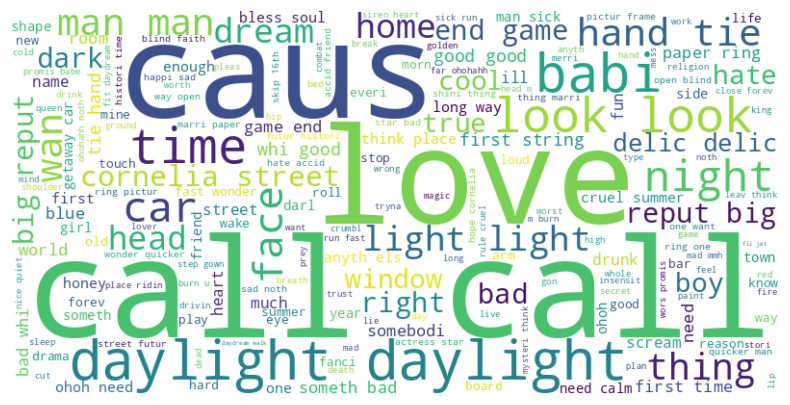

In [97]:
wc_df = playlist_df[playlist_df['playlist_name'] == 'This Is Taylor Swift']
wc_df['processed_lyrics']

import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

content_model_recommendations_name['processed_lyrics']
recommendations_lyrics = " ".join(wc_df['processed_lyrics'])
shape_mask = "spotify_logo.png"
nlp = spacy.load("en_core_web_sm")
# Process the text using spaCy
doc = nlp(recommendations_lyrics)

# Extract nouns from the processed text
nouns = [token.text for token in doc if token.pos_ == "NOUN" or token.pos_ == "ADJ"]

# Combine the extracted nouns into a single string
noun_text = " ".join(nouns)

# Create a WordCloud object and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(noun_text)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

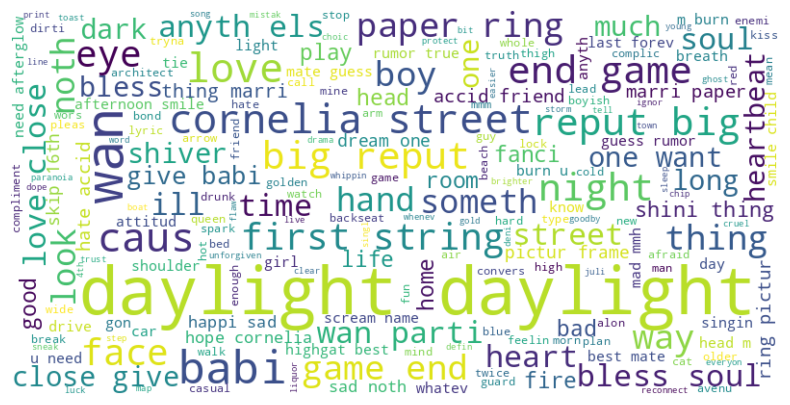

In [96]:
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

recommendations_lyrics = " ".join(content_model_recommendations_name['processed_lyrics'][:10])

nlp = spacy.load("en_core_web_sm")
# Process the text using spaCy
doc = nlp(recommendations_lyrics)

# Extract nouns from the processed text
nouns = [token.text for token in doc if token.pos_ == "NOUN" or token.pos_ == "ADJ"]

# Combine the extracted nouns into a single string
noun_text = " ".join(nouns)

# Create a WordCloud object and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(noun_text)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [98]:
# Get the keywords for my "Weird mix" playlist
#soft_pop_profile = playlist_profiles[playlist_ids['Soft Pop Hits']]
#print(soft_pop_profile.shape)  # 95 songs of vector length 948
#pd.DataFrame(sorted(zip(tfidf_feature_names, soft_pop_profile.flatten().tolist()), key=lambda x: -x[1])[:10],  # sort by value desc
             #columns=['token', 'relevance'])

KeyError: ignored

In [ ]:
##content_model_recommendations = content_model.recommend_tracks(playlist_ids['Apocalypse'], interacted_tracks['id'].tolist())
# Get track details from original track data
#content_model_recommendations_name = pd.merge(content_model_recommendations, playlist_df.drop_duplicates(subset='id', keep="first"), how='left', on='id')
#content_model_recommendations_name[['id', 'name', 'artist_name', 'album_name', 'recStrength']].head()

,id,name,artist_name,album_name,recStrength
0,3AVrVz5rK8Hrqo9YGiVGN5,Apocalypse,Cigarettes After Sex,Cigarettes After Sex,1.000000
1,4uzUuDjoufcBXYZ27CsLIF,Roses,Shawn Mendes,Illuminate (Deluxe),0.204777
2,5IonbH68pmDKBwcKlyswmR,John Wayne,Cigarettes After Sex,Cigarettes After Sex,0.188144
3,07A4mFpXnuUrcRIc1S8ilz,Bad Reputation,Shawn Mendes,Illuminate,0.167809
4,5ld8E3DVBXCCWQ54yrkWVp,305,Shawn Mendes,Wonder,0.097554


In [ ]:
#wc_df = playlist_df[playlist_df['playlist_name'] == 'Apocalypse']
#wc_df['processed_lyrics']

1    leapt crumbl bridg watch cityscap turn dust fi...
Name: processed_lyrics, dtype: object

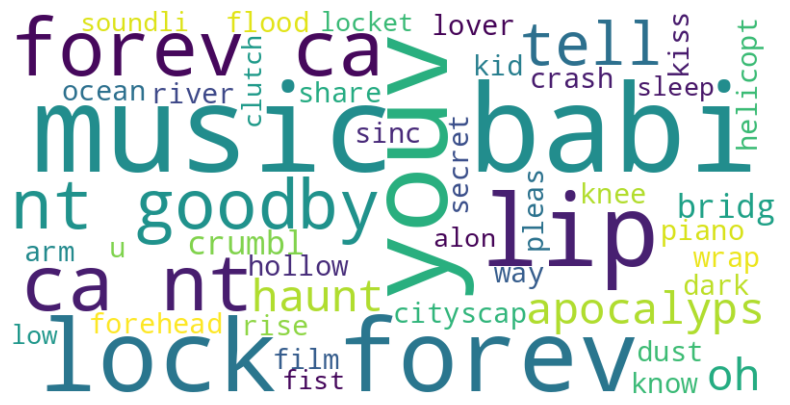

In [ ]:
#import spacy
#from wordcloud import WordCloud
#import matplotlib.pyplot as plt

#content_model_recommendations_name['processed_lyrics']
#recommendations_lyrics = " ".join(wc_df['processed_lyrics'])

#nlp = spacy.load("en_core_web_sm")
# Process the text using spaCy
#doc = nlp(recommendations_lyrics)

# Extract nouns from the processed text
#nouns = [token.text for token in doc if token.pos_ != "VERB"]

# Combine the extracted nouns into a single string
#noun_text = " ".join(nouns)

# Create a WordCloud object and generate the word cloud
#wordcloud = WordCloud(width=800, height=400, background_color="white").generate(noun_text)

# Display the word cloud using Matplotlib
#plt.figure(figsize=(10, 5))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show()

In [ ]:
#len(content_model_recommendations_name)

25

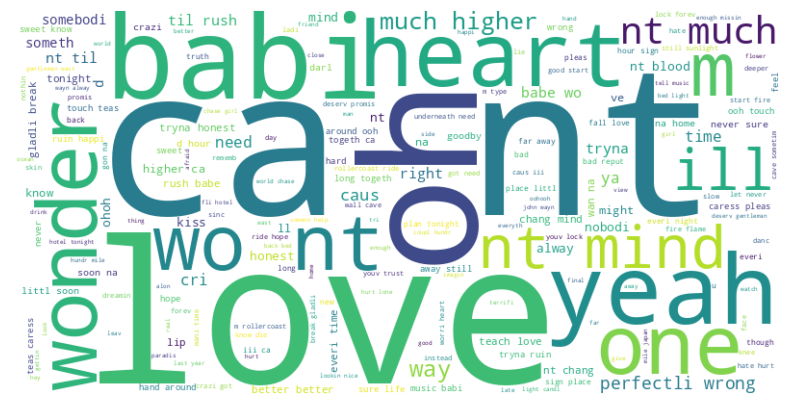

In [ ]:
#import spacy
#from wordcloud import WordCloud
#import matplotlib.pyplot as plt

#content_model_recommendations_name['processed_lyrics']
#recommendations_lyrics = " ".join(content_model_recommendations_name['processed_lyrics'])

#nlp = spacy.load("en_core_web_sm")
# Process the text using spaCy
#doc = nlp(recommendations_lyrics)

# Extract nouns from the processed text
#nouns = [token.text for token in doc if token.pos_ != "VERB"]

# Combine the extracted nouns into a single string
#noun_text = " ".join(nouns)

# Create a WordCloud object and generate the word cloud
#wordcloud = WordCloud(width=800, height=400, background_color="white").generate(noun_text)

# Display the word cloud using Matplotlib
#plt.figure(figsize=(10, 5))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show()

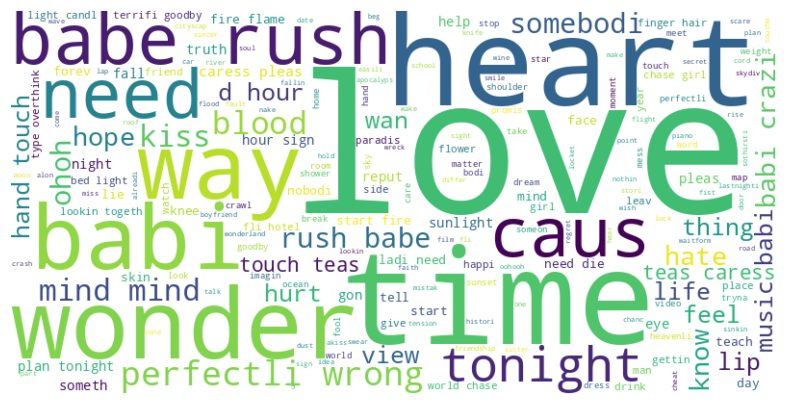

In [ ]:
#import spacy
#from wordcloud import WordCloud
#import matplotlib.pyplot as plt

#content_model_recommendations_name['processed_lyrics']
#recommendations_lyrics = " ".join(content_model_recommendations_name['processed_lyrics'])

#nlp = spacy.load("en_core_web_sm")
# Process the text using spaCy
#doc = nlp(recommendations_lyrics)

# Extract nouns from the processed text
#nouns = [token.text for token in doc if token.pos_ == "NOUN"]

# Combine the extracted nouns into a single string
#noun_text = " ".join(nouns)

# Create a WordCloud object and generate the word cloud
#wordcloud = WordCloud(width=800, height=400, background_color="white").generate(noun_text)

# Display the word cloud using Matplotlib
#plt.figure(figsize=(10, 5))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show()

##Collaborative Recommender: Matrix Factorisation

In [100]:
#Creating a sparse pivot table with users in rows and items in columns
playlist_df['event_strength'] = 1  ## create dummy column for pivot value
playlist_matrix_df = playlist_df.pivot_table(index='playlist_id',
                                                           columns='id_x',
                                                           values='event_strength',
                                                           aggfunc='sum',
                                                          ).fillna(0)

playlist_matrix_df.values

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [101]:
playlist_matrix = playlist_matrix_df.values
playlist_sparse = csr_matrix(playlist_matrix)
playlist_sparse

<9x158 sparse matrix of type '<class 'numpy.float64'>'
	with 175 stored elements in Compressed Sparse Row format>

In [102]:
print(playlist_sparse.shape)

(9, 158)


In [103]:
# Performs matrix factorisation of the original user item matrix
u, s, vt = svds(playlist_sparse, k = 3)  # k is number of factors
s = np.diag(s)
print(u.shape, vt.shape, s.shape)

(9, 3) (3, 158) (3, 3)


In [104]:
playlist_predicted_ratings = np.dot(np.dot(u, s), vt)
playlist_predicted_ratings
# MinMaxScaler doesn't work for global min(), max()
playlist_predicted_ratings_norm = (playlist_predicted_ratings - playlist_predicted_ratings.min()
                                  ) / (playlist_predicted_ratings.max() - playlist_predicted_ratings.min())
playlist_predicted_ratings_norm

array([[9.49225734e-01, 0.00000000e+00, 9.69726167e-18, ...,
        9.69726167e-18, 9.69726167e-18, 2.09734812e-02],
       [2.14654861e-02, 3.60865893e-02, 3.60865893e-02, ...,
        3.60865893e-02, 3.60865893e-02, 2.09734812e-02],
       [2.84453009e-16, 4.63142297e-01, 4.63142297e-01, ...,
        4.63142297e-01, 4.63142297e-01, 2.09734812e-02],
       ...,
       [3.32629955e-02, 4.70684877e-01, 4.70684877e-01, ...,
        4.70684877e-01, 4.70684877e-01, 2.09734812e-02],
       [2.09734812e-02, 2.09734812e-02, 2.09734812e-02, ...,
        2.09734812e-02, 2.09734812e-02, 2.09734812e-02],
       [2.09734812e-02, 2.09734812e-02, 2.09734812e-02, ...,
        2.09734812e-02, 2.09734812e-02, 9.52655274e-01]])

In [105]:
#Converting the reconstructed matrix back to a Pandas dataframe
matrix_preds_df = pd.DataFrame(playlist_predicted_ratings_norm, columns = playlist_matrix_df.columns,
                               index=playlist_df['playlist_id'].unique()).transpose()
matrix_preds_df.shape

(158, 9)

In [106]:
playlist_df['playlist_id']

0      6LTmMLBh0J9C9SZLhrjIge
1      6LTmMLBh0J9C9SZLhrjIge
2      6LTmMLBh0J9C9SZLhrjIge
3      6LTmMLBh0J9C9SZLhrjIge
4      6LTmMLBh0J9C9SZLhrjIge
                ...          
170    37i9dQZF1DX5KpP2LN299J
171    37i9dQZF1DX5KpP2LN299J
172    37i9dQZF1DX5KpP2LN299J
173    37i9dQZF1DX5KpP2LN299J
174    37i9dQZF1DX5KpP2LN299J
Name: playlist_id, Length: 175, dtype: object

In [117]:
class CollaborativeRecommender:

    def __init__(self, tracks, matrix_preds_df):
        self.tracks = tracks
        self.matrix_preds_df = matrix_preds_df
        self.model_name = 'Collaborative Recommender'

    def recommend_tracks(self, playlist_id, ignore_ids=[]):
        sorted_playlist_predictions = self.matrix_preds_df[playlist_id].sort_values(ascending=False) \
                                        .reset_index().rename(columns={playlist_id: 'recStrength'})
        recommendations_df = sorted_playlist_predictions[~sorted_playlist_predictions['id_x'].isin(ignore_ids)] \
                                .drop_duplicates(subset='id_x', keep="first").reset_index() \
                                .sort_values('recStrength', ascending = False)

        return recommendations_df

collaborative_model = CollaborativeRecommender(playlist_df, matrix_preds_df)

In [118]:
collaborative_model_recommendations = collaborative_model.recommend_tracks(playlist_ids['Top Songs - USA'], interacted_tracks['id_x'].tolist())
# Get track details from original track data
collaborative_model_recommendations_name = pd.merge(collaborative_model_recommendations, playlist_df.drop_duplicates(subset='id_x', keep="first"), how='left', on='id_x')
collaborative_model_recommendations_name[['id_x', 'name', 'artist_name', 'album_name', 'recStrength']].head()

,id_x,name,artist_name,album_name,recStrength
0,7xpstFePAiqtVhcWpkBWGc,The Journey,Last Days of Eden,Butterflies,0.020973
1,6uCmU6ldcsVpLAKNCojVg8,Fire Escape,Andrew McMahon in the Wilderness,Zombies On Broadway,0.020973
2,0KFPXmDGvCFQQx0pmPxQx9,Seconds of Jefferson,Newton James,Seconds of Jefferson,0.020973
3,39zZYlOqcWXRe69fjsf0ik,Lucky Star,Club Intl,Italians Do It Better,0.020973
4,44ot7aqyz0T5SbCvxwXoFp,to the last of a dying breed,Wu Am I,to the last of a dying breed,0.020973


In [119]:
collaborative_model_recommendations_name[['id_x', 'name', 'artist_name', 'album_name', 'recStrength']]

,id_x,name,artist_name,album_name,recStrength
0,7xpstFePAiqtVhcWpkBWGc,The Journey,Last Days of Eden,Butterflies,0.020973
1,6uCmU6ldcsVpLAKNCojVg8,Fire Escape,Andrew McMahon in the Wilderness,Zombies On Broadway,0.020973
2,0KFPXmDGvCFQQx0pmPxQx9,Seconds of Jefferson,Newton James,Seconds of Jefferson,0.020973
3,39zZYlOqcWXRe69fjsf0ik,Lucky Star,Club Intl,Italians Do It Better,0.020973
4,44ot7aqyz0T5SbCvxwXoFp,to the last of a dying breed,Wu Am I,to the last of a dying breed,0.020973
...,...,...,...,...,...
151,7IL8PSVwLOJxqYne6azxQv,Pretty Boy,The Neighbourhood,Chip Chrome & The Mono-Tones,0.020973
152,0wBhns0U4sljWwPkCCQsPJ,Help,Serhat Durmus,Arres,0.020973
153,7LHp74RcZNzo19YH6ZX3mL,Sorry,Alex Kehm,Sorry,0.020973
154,0axh6dkQ45HyGrllVPAgiL,Comedown Outro,Skinny Girl Diet,Heavy Flow,0.020973


##Hybrid Recommender

In [122]:
class HybridRecommender:

    def __init__(self, tracks, content_model, collaborative_model, content_weight=2, collaborative_weight=1):
        self.tracks = tracks
        self.model_name = 'Hybrid Recommender'
        self.content_model = content_model
        self.collaborative_model = collaborative_model
        # Relative weights
        self.content_weight = content_weight
        self.collaborative_weight = collaborative_weight

    def recommend_tracks(self, playlist_id, ignore_ids=[]):

        content_recs_df = self.content_model.recommend_tracks(
            playlist_id, ignore_ids).rename(columns={'recStrength': 'recStrengthContent'})
        collaborative_recs_df = self.collaborative_model.recommend_tracks(
            playlist_id, ignore_ids).rename(columns={'recStrength': 'recStrengthCollaborative'})
        combined_recs_df = content_recs_df.merge(collaborative_recs_df,
                                                 how = 'outer',
                                                 on = 'id_x',
                                                ).fillna(0)
        # Compute hybrid score based on weights
        combined_recs_df['recStrengthHybrid'] = (combined_recs_df['recStrengthContent'] * self.content_weight) \
                                                + (combined_recs_df['recStrengthCollaborative'] * self.collaborative_weight)
        recommendations_df = combined_recs_df \
                                .drop_duplicates(subset='id_x', keep="first").reset_index() \
                                .sort_values('recStrengthHybrid', ascending=False)

        return recommendations_df

hybrid_model = HybridRecommender(playlist_df, content_model, collaborative_model)

In [123]:
hybrid_model_recommendations = hybrid_model.recommend_tracks(playlist_ids['This Is Taylor Swift'], interacted_tracks['id_x'].tolist())
# Get track details from original track data
hybrid_model_recommendations_name = pd.merge(hybrid_model_recommendations, playlist_df.drop_duplicates(subset='id_x', keep="first"), how='left', on='id_x')
hybrid_model_recommendations_name[['id_x', 'name', 'artist_name', 'album_name', 'recStrengthHybrid']].head()

,id_x,name,artist_name,album_name,recStrengthHybrid
0,2iUXsYOEPhVqEBwsqP70rE,Youngblood,5 Seconds of Summer,Youngblood (Deluxe),1.349086
1,3jjujdWJ72nww5eGnfs2E7,Adore You,Harry Styles,Fine Line,1.348517
2,5cF0dROlMOK5uNZtivgu50,Attention,Charlie Puth,Voicenotes,1.284268
3,50nfwKoDiSYg8zOCREWAm5,Shivers,Ed Sheeran,=,1.261626
4,2BgEsaKNfHUdlh97KmvFyo,2002,Anne-Marie,Speak Your Mind (Deluxe),1.246863


In [124]:
hybrid_model_recommendations_name[['id_x', 'name', 'artist_name', 'album_name', 'recStrengthHybrid']]

,id_x,name,artist_name,album_name,recStrengthHybrid
0,2iUXsYOEPhVqEBwsqP70rE,Youngblood,5 Seconds of Summer,Youngblood (Deluxe),1.349086
1,3jjujdWJ72nww5eGnfs2E7,Adore You,Harry Styles,Fine Line,1.348517
2,5cF0dROlMOK5uNZtivgu50,Attention,Charlie Puth,Voicenotes,1.284268
3,50nfwKoDiSYg8zOCREWAm5,Shivers,Ed Sheeran,=,1.261626
4,2BgEsaKNfHUdlh97KmvFyo,2002,Anne-Marie,Speak Your Mind (Deluxe),1.246863
...,...,...,...,...,...
151,6zxDwS9eW75KWc4atP6YZN,Knights of the Burning Crypt,Vampire,With Primeval Force,0.128005
152,0axh6dkQ45HyGrllVPAgiL,Comedown Outro,Skinny Girl Diet,Heavy Flow,0.109258
153,2OR4Xsd5n8fjkeJcl8etbA,Teacher Is Mad,The Obsessives,Great Menace,0.102354
154,7xpstFePAiqtVhcWpkBWGc,The Journey,Last Days of Eden,Butterflies,0.097168


In [126]:
# Filter tracks where recStrengthHybrid >= 1.15
tracks_to_add = hybrid_model_recommendations[hybrid_model_recommendations['recStrengthHybrid'] >= 1.00]['id_x']
print(len(tracks_to_add))

14


##Adding recommendations to spotify

In [ ]:
# Spotify API
with open("spotify_details.yml", 'r') as stream:
    spotify_details = yaml.safe_load(stream)

scope = "playlist-modify-private"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=spotify_details['client_id'],
    client_secret=spotify_details['client_secret'],
    redirect_uri=spotify_details['redirect_uri'],
    scope=scope,
))

# Create a new playlist for tracks to add - you may also add these tracks to your source playlist and proceed
new_playlist = sp.user_playlist_create(user="User",
                                       name="spotify-recommender-systems",
                                       public=False,
                                       collaborative=False,
                                       description="Created for Music Data Mining",
                                      )

# Add tracks to the new playlist
for id in tracks_to_add:
    sp.user_playlist_add_tracks(user="User",
                                playlist_id=new_playlist['id'],
                                tracks=[id],
                               );